In [1]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pickle

In [2]:
config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

/home/user/pytorch/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [3]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]
def resize_image(image, re_type, *args, upsize = False, path = True):
    if path:
        img = Image.open(image)
    else:
        img = image
    if re_type == 'Scale':
        sf = args[0]
        if not sf:
            return img
        width, height = img.size
        if upsize:
            img = img.resize((int(width / sf), int(height / sf)))
            img = img.resize((width, height))
        else:
            img = img.resize((int(width / sf), int(height / sf)))
    elif re_type == 'Percent':
        percent_c = args[0]
        width, height = img.size
        if upsize:
            img = img.resize((int(width * percent_c), int(height * percent_c)))
            img = img.resize((width, height))
        else:
            img = img.resize((int(width * percent_c), int(height * percent_c)))
    else:
        img = img.resize(args)
    return img
def display_detections(list_of_imgs, resize_type, resize_arg, save = True, path = True, visualize = True):
    x_coord = []
    class_pred = []
    for i in list_of_imgs:
        count = 0
        # load image and get detections
        if path:
            img_path = i
            img = resize_image(img_path, resize_type, resize_arg, upsize = True, path = True)
        else:
            img = resize_image(i, resize_type, resize_arg, upsize = True, path = False)
        prev_time = time.time()
        detections = detect_image(img)
        inference_time = datetime.timedelta(seconds=time.time() - prev_time)
        # print ('Inference Time: %s' % (inference_time))

        # Get bounding-box colors
        if visualize:
            cmap = plt.get_cmap('tab20b')
            colors = [cmap(i) for i in np.linspace(0, 1, 20)]

            img = np.array(img)
            plt.figure()
            fig, ax = plt.subplots(1, figsize=(8,9))
            ax.imshow(img)

            pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
            pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
            unpad_h = img_size - pad_y
            unpad_w = img_size - pad_x

        if detections is not None:
            unique_labels = detections[:, -1].cpu().unique()
            n_cls_preds = len(unique_labels)
            if visualize:
                bbox_colors = random.sample(colors, n_cls_preds)
            # browse detections and draw bounding boxes
            for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
                if visualize:
                    box_h = ((y2 - y1) / unpad_h) * img.shape[0]
                    box_w = ((x2 - x1) / unpad_w) * img.shape[1]
                    y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
                    x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
                    color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
                    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
                    ax.add_patch(bbox)
                    plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top', bbox={'color': color, 'pad': 0})
                if int(cls_pred) == 47:
                    x_coord.append(float(conf))
                count += 1
                class_pred.append(cls_pred)
        if visualize:
            plt.axis('off')
            plt.show()
        # save image
        if save:
            plt.savefig(img_path.replace(".jpg", "-det.jpg"), bbox_inches='tight', pad_inches=0.0)
    return class_pred, x_coord
def reduce_index(list_of_indexes, only_one = False):
    res = []
    for i in list_of_indexes:
        print(i)
        img, target = cap[i]
        img_to_pil = torchvision.transforms.ToPILImage()
        temp = img_to_pil(img)
        class_pred, xval = display_detections([temp], 'Scale', 0, save = False, path = False, visualize = False)
        if only_one:
            if 47 in class_pred and class_pred.count(47) == 1:
                res.append(i)
        else:
            if 47 in class_pred:
                res.append(i)
    return res
def save_pickle():
    pickle_out1 = open("coco_dataset_apple_img_indexes.pickle","wb")
    pickle.dump(index, pickle_out1)
    pickle_out1.close()
    pickle_out2 = open("coco_dataset_img_and_captions.pickle","wb")
    pickle.dump(cap, pickle_out2)
    pickle_out2.close()
    pickle_out3 = open("coco_dataset_only_apples.pickle", "wb")
    pickle.dump(new_indexes, pickle_out3)
    pickle_out3.close()
    return 'Done'
def load_pickle():
    pickle_in1 = open("coco_dataset_apple_img_indexes.pickle","rb")
    index = pickle.load(pickle_in1)
    pickle_in2 = open("coco_dataset_img_and_captions.pickle", "rb")
    cap = pickle.load(pickle_in2)
    pickle_in3 = open("coco_dataset_only_apples.pickle", "rb")
    new_indexes = pickle.load(pickle_in3)
    return index, cap, new_indexes
def display_graph(percent_chg):
    %matplotlib inline
    per_chg = percent_chg
    percentshow = []
    print(per_chg)
    num_of_imgs = len(new_indexes1)
    starttime = time.time()
    for pctc in per_chg:
        coco_imgs = []
        for i in range(num_of_imgs):
            img, target = cap[new_indexes1[i]]
            img_to_pil = torchvision.transforms.ToPILImage()
            temp = img_to_pil(img)
            coco_imgs.append(temp)
        class_predictions, x_vals = display_detections(coco_imgs, 'Percent', pctc, save = False, path = False, visualize = False)
        percentshow.append(len(x_vals) / num_of_imgs)
    print(percentshow)
    print('Runtime: ', time.time() - starttime)
    plt.plot(per_chg, percentshow)
    return 'Done'

In [4]:
index, cap, new_indexes = load_pickle()
%matplotlib inline
new_indexes1 = reduce_index(index, only_one=True)

295
392
577
599
629
705
844
1356
1534
1545
1548
1786
2164
2390
2859
3270
3360
3454
3551
3677
3683
3748
4011
4179
4226
4285
4402
5010
5157
5243
5914
6587
7404
7424
7436
7438
7468
7825
8119
8291
8717
8768
8874
9078
9094
9263
9306
9609
10208
10480
10904
10944
11223
11274
11308
11333
11601
11825
11847
11983
12144
12154
12253
12480
12495
12613
12956
13081
13247
13586
13619
13886
13927
13988
14610
14640
14735
14749
14953
15155
15418
15777
15942
16194
16408
16414
16456
16691
16823
17575
17971
18065
18385
18396
18549
18664
18762
19005
19043
19232
20202
20928
21137
21399
21405
21516
21550
21993
22205
22232
22234
22411
22505
22548
23050
23066
23391
23780
23838
24143
24321
24332
24459
24663
24847
24899
25067
25402
25540
25869
26551
26846
26941
27182
27235
27722
27867
27972
28239
28399
28416
28911
29077
29245
29533
29804
30069
30439
30461
30683
30818
30846
30865
30932
31380
31425
31433
31508
31608
31640
31667
31739
31874
31923
32188
32288
32297
33434
33987
34063
34332
34669
36335
36355
37527
37943

[1.0, 0.98, 0.96, 0.94, 0.92, 0.9, 0.88, 0.86, 0.84, 0.82, 0.8, 0.78, 0.76, 0.74, 0.72, 0.7, 0.68, 0.66, 0.64, 0.62, 0.6, 0.58, 0.56, 0.54, 0.52, 0.5, 0.48, 0.46, 0.44, 0.42, 0.4, 0.38, 0.36, 0.34, 0.32, 0.3, 0.28, 0.26, 0.24, 0.22, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02]
[1.0, 0.9875776397515528, 0.9813664596273292, 0.9751552795031055, 0.9813664596273292, 1.0, 0.9813664596273292, 0.9751552795031055, 0.968944099378882, 0.9751552795031055, 0.9937888198757764, 0.9813664596273292, 0.9813664596273292, 0.9875776397515528, 0.9875776397515528, 0.968944099378882, 0.9813664596273292, 0.968944099378882, 0.9751552795031055, 0.968944099378882, 0.968944099378882, 0.9565217391304348, 0.9565217391304348, 0.9627329192546584, 0.9627329192546584, 0.9440993788819876, 0.937888198757764, 0.9440993788819876, 0.9192546583850931, 0.9130434782608695, 0.906832298136646, 0.9006211180124224, 0.8881987577639752, 0.8819875776397516, 0.8944099378881988, 0.8633540372670807, 0.8633540372670807, 0.819

'Done'

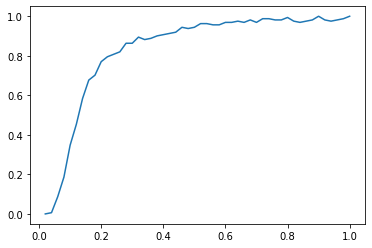

In [5]:
percent_change = (np.arange(1, 0, -0.02)).round(decimals = 2).tolist()
display_graph(percent_change)